C:\Users\prate\AppData\Local\conda\conda\envs\mlenv\lib\site-packages\tensorflow\python\client\session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
100%|###########################################################################| 10000/10000 [00:25<00:00, 388.47it/s]


0.19952210783958435
Training Accuracy: 19.952210783958435%
0.20430107414722443
Training Accuracy: 20.430107414722443%


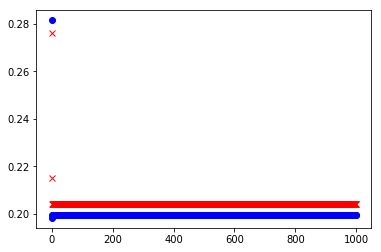

In [7]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline 
from tqdm import tqdm

dataset = np.load('data_with_labels.npz')
train = dataset['arr_0']/255.
labels = dataset['arr_1']

def to_onehot(labels, nclasses=5):
    out = np.zeros((len(labels),nclasses))
    for i,l in enumerate(labels):
        out[i,l] = 1
    return out

onehot = to_onehot(labels)

indices = np.random.permutation(train.shape[0])
val_cnt = int(train.shape[0]*.1)
train_idx, val_idx = indices[val_cnt:], indices[:val_cnt]
train, val = train[train_idx,:], train[val_idx,:]
onehot_train, onehot_val = onehot[train_idx,:], onehot[val_idx,:]

sess = tf.InteractiveSession()

#known
x = tf.placeholder('float', [None,1296])
y_ = tf.placeholder('float', [None,5])

#hidden layer 
hidden_num_layer= 128
W1 = tf.Variable(tf.truncated_normal([1296,hidden_num_layer], 
                                     stddev=1./math.sqrt(1296)))
b1 = tf.Variable(tf.constant(0.1, shape=[hidden_num_layer]))
A1 = tf.sigmoid(tf.matmul(x,W1)+b1)

#output Layer
W2 = tf.Variable(tf.truncated_normal([hidden_num_layer,5], stddev=1./math.sqrt(5)))
b2 = tf.Variable(tf.constant(0.1, shape=[5]))
sess.run(tf.initialize_all_variables())

y = tf.nn.softmax(tf.matmul(A1,W2)+b2)

cross_entropy = tf.reduce_sum(
    tf.nn.softmax_cross_entropy_with_logits(logits=y+1e-20,labels=y_))

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y,1),
                     tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(
           correct_prediction, "float"))

epochs= 10000
train_acc = np.zeros(epochs//10)
val_acc = np.zeros(epochs//10)

#Training
for  i in tqdm(range(epochs), ascii=True):
    if i%10 == 0:
        #train acc
        train_a = accuracy.eval(feed_dict={
            x : train.reshape([-1,1296]),
            y_: onehot_train
        })
        train_acc[i//10] =train_a
        #val acc
        val_a = accuracy.eval(feed_dict={
            x: val.reshape([-1,1296]),
            y_: onehot_val
        })
        val_acc[i//10] = val_a
        train_step.run(feed_dict={
            x : train.reshape([-1,1296]),
            y_ : onehot_train
        })

print(train_acc[-1])
print('Training Accuracy: {}%'.format(train_acc[-1]*100))
print(val_acc[-1])
print('Training Accuracy: {}%'.format(val_acc[-1]*100))

plt.plot(train_acc, 'bo')
plt.plot(val_acc, 'rx')

In [1]:
import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm

# Load data
data = np.load('data_with_labels.npz')
train = data['arr_0']/255.
labels = data['arr_1']

# Look at some data
print(train[0])
print(labels[0])

# If you have matplotlib installed
import matplotlib.pyplot as plt
plt.ion()

def to_onehot(labels,nclasses = 5):
    '''
    Convert labels to "one-hot" format.

    >>> a = [0,1,2,3]
    >>> to_onehot(a,5)
    array([[ 1.,  0.,  0.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.],
           [ 0.,  0.,  1.,  0.,  0.],
           [ 0.,  0.,  0.,  1.,  0.]])
    '''
    outlabels = np.zeros((len(labels),nclasses))
    for i,l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

# Split data into training and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt], indices[valid_cnt:]
test, train = train[test_idx,:], train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:], onehot[training_idx,:]

sess = tf.InteractiveSession()


# These will be inputs
## Input pixels, flattened
x = tf.placeholder("float", [None, 1296])
## Known labels
y_ = tf.placeholder("float", [None,5])

# Hidden layer
num_hidden = 128
W1 = tf.Variable(tf.truncated_normal([1296, num_hidden],
                                        stddev=1./math.sqrt(1296)))
b1 = tf.Variable(tf.constant(0.1,shape=[num_hidden]))
h1 = tf.sigmoid(tf.matmul(x,W1) + b1)

# Output Layer
W2 = tf.Variable(tf.truncated_normal([num_hidden, 5],
                                        stddev=1./math.sqrt(5)))
b2 = tf.Variable(tf.constant(0.1,shape=[5]))

# Just initialize
sess.run(tf.initialize_all_variables())

# Define model
y = tf.nn.softmax(tf.matmul(h1,W2) + b2)

### End model specification, begin training code


# Climb on cross-entropy
cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=y + 1e-20, labels=y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# Actually train
epochs = 10000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)
for i in tqdm(range(epochs), ascii=True):
    if i % 10 == 0:  # Record summary data, and the accuracy
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={x: train.reshape([-1,1296]), y_: onehot_train})
        train_acc[i//10] = A

        # And now the validation set
        A = accuracy.eval(feed_dict={x: test.reshape([-1,1296]), y_: onehot_test})
        test_acc[i//10] = A
    train_step.run(feed_dict={x: train.reshape([-1,1296]), y_: onehot_train})

# Plot the accuracy curves
plt.plot(train_acc,'bo')
plt.plot(test_acc,'rx')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



100%|############################################################################| 10000/10000 [02:26<00:00, 70.46it/s]


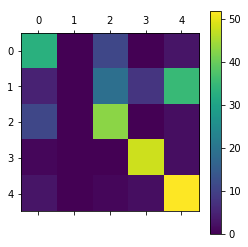

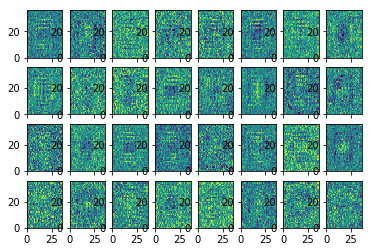

In [2]:
# Look at the final testing confusion matrix
pred = np.argmax(y.eval(feed_dict={x: test.reshape([-1,1296]), y_: onehot_test}), axis = 1)
conf = np.zeros([5,5])
for p,t in zip(pred,np.argmax(onehot_test,axis=1)):
    conf[t,p] += 1

plt.matshow(conf)
plt.colorbar()


# Let's look at a subplot of some weights
f, plts = plt.subplots(4,8, sharex=True)
for i in range(32):
    plts[i//8, i%8].pcolormesh(W1.eval()[:,i].reshape([36,36]))

In [3]:
import matplotlib.pyplot as plt
# Plot the accuracy curves
plt.plot(train_acc,'bo')
plt.plot(test_acc,'rx')

NameError: name 'train_acc' is not defined